In [1]:
import numpy as np
import rasterio
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Load the predictor variables
with rasterio.open('data/aggregated_over_years_model_input/sm_min_pro.tif') as src:
    sm_min = src.read(1)  # Read the first band

with rasterio.open('data/aggregated_over_years_model_input/lai_min_pro.tif') as src:
    lai_min = src.read(1)  # Read the first band

with rasterio.open('data/aggregated_over_years_model_input/lai_sum_mean_pro.tif') as src:
    lai_sum_mean = src.read(1)  # Read the first band

with rasterio.open('data/aggregated_over_years_model_input/t_max_pro.tif') as src:
    t_max = src.read(1)  # Read the first band

with rasterio.open('data/aggregated_over_years_model_input/index_max_pro.tif') as src:
    index_max = src.read(1)  # Read the first band

with rasterio.open('data/aggregated_over_years_model_input/index_severity_pro.tif') as src:
    index_severity = src.read(1)  # Read the first band

with rasterio.open('data/aggregated_over_years_model_input/index_len_pro.tif') as src:
    index_len = src.read(1)  # Read the first band


# Load the response variable
with rasterio.open('data/dead/deadwood.tif') as src:
    deadwood = src.read(1)  # Read the first band

In [7]:
# Flatten the arrays to 1D
sm_min_flat = sm_min.flatten()
lai_min_flat = lai_min.flatten()
lai_sum_mean_flat = lai_sum_mean.flatten()
t_max_flat = t_max.flatten()
index_max_flat = index_max.flatten()
index_severity_flat = index_severity.flatten()
index_len_flat = index_len.flatten()
deadwood_flat = deadwood.flatten()


# Stack predictor variables into a single array
X = np.column_stack((sm_min_flat, lai_min_flat, lai_sum_mean_flat, t_max_flat, index_max_flat, index_severity_flat, index_len_flat))
#X = np.column_stack((sm_min_flat, lai_min_flat, lai_sum_mean_flat, t_max_flat))

y = deadwood_flat

# Remove rows with NAs and entries with -32768.0 in deadwood_flat
mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y) & (y != -32768.0)
X_clean = X[mask]
y_clean = y[mask]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=400)


In [8]:
# Use GridsearchCV for this
param_grid = {
    'ccp_alpha': [0.01],  # Vary the complexity parameter (cp)
    'max_depth': [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features' : ['sqrt', 'log2'], #The number of features to consider when looking for the best split:
    'n_estimators' :  [2000] # numbers of trees in a forest
}


# Create the model
rf = RandomForestRegressor(random_state=123, oob_score=True )


# Perform grid search with cross-validation
grid_search = GridSearchCV(rf, param_grid, cv = 5, scoring = 'neg_mean_squared_error', verbose=2, n_jobs=-1 ) #set by default for classification

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[CV] END ccp_alpha=0.01, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=  10.9s
[CV] END ccp_alpha=0.01, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=  10.9s
[CV] END ccp_alpha=0.01, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=  10.9s
[CV] END ccp_alpha=0.01, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=  11.0s
[CV] END ccp_alpha=0.01, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   8.2s
[CV] END ccp_alpha=0.01, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   8.2s
[CV] END ccp_alpha=0.01, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   8.2s
[CV] END ccp_alpha=0.01, ma

In [9]:
# Print the best parameters
print("Best parameters:", grid_search.best_params_)

best_rf = grid_search.best_estimator_
oob_score = best_rf.oob_score_

print("OOB Score of the best model:", oob_score)

Best parameters: {'ccp_alpha': 0.01, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2000}
OOB Score of the best model: 0.6208015745441191


# colinearity / correlation

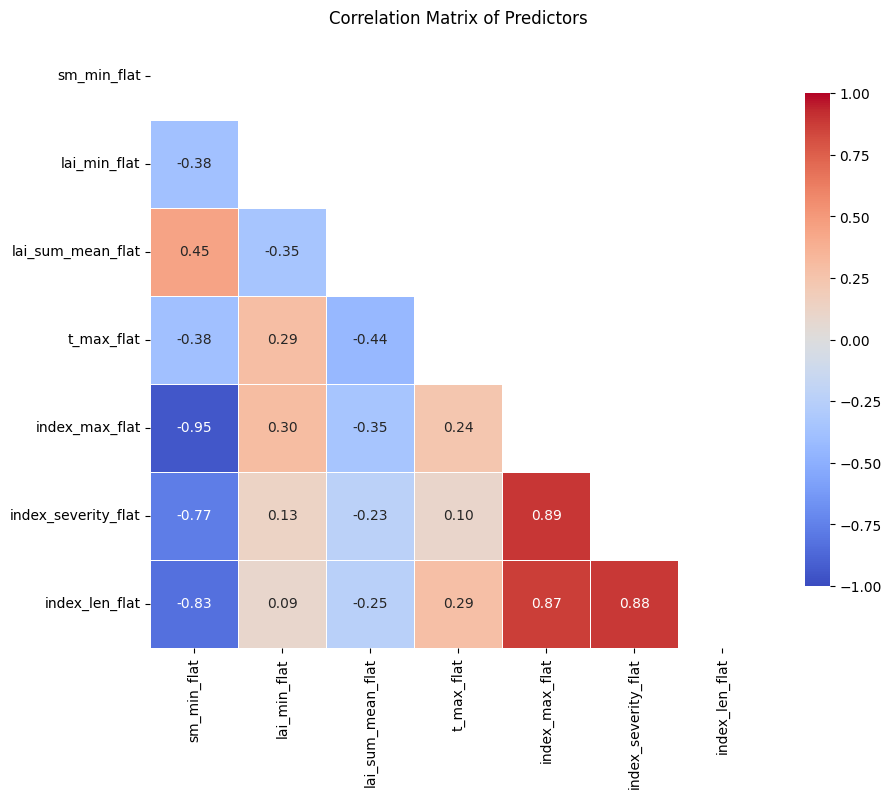

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X_clean is a numpy array with your cleaned predictors
# Create a DataFrame for better handling with columns named according to your predictors
df_predictors = pd.DataFrame(X_clean, columns=['sm_min_flat', 'lai_min_flat', 'lai_sum_mean_flat', 't_max_flat', 'index_max_flat', 'index_severity_flat', 'index_len_flat'])

# Compute the correlation matrix
corr_matrix = df_predictors.corr()

# Generate a mask for the upper triangle (optional, for aesthetics)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
            vmax=1, vmin=-1, square=True, linewidths=.5, cbar_kws={"shrink": .8})

# Add titles and labels for clarity
plt.title('Correlation Matrix of Predictors')
plt.show()


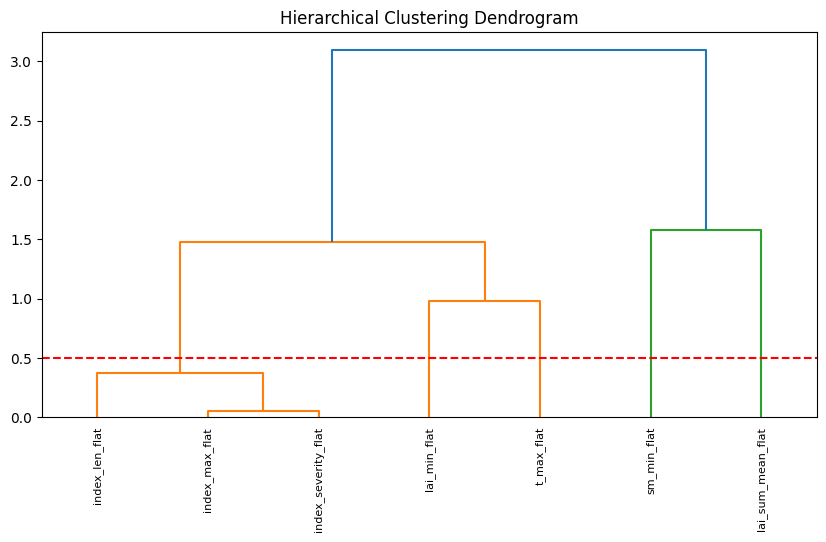

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import spearmanr

# Assuming you have imported your data into a pandas DataFrame called mydata
mydata = pd.DataFrame(X_clean, columns=['sm_min_flat', 'lai_min_flat', 'lai_sum_mean_flat', 't_max_flat', 'index_max_flat', 'index_severity_flat', 'index_len_flat'])

# Calculate Spearman's rank correlation coefficient matrix
corr_matrix = mydata.corr(method='spearman')

# Perform hierarchical clustering
Z = linkage(corr_matrix, method='average')

# Plot dendrogram
plt.figure(figsize=(10, 5))
plt.title('Hierarchical Clustering Dendrogram')
dendrogram(Z, labels=corr_matrix.columns, leaf_rotation=90, leaf_font_size=8)
plt.axhline(y=0.5, color='red', linestyle='--')  # Adding the horizontal line at 0.5
plt.show()


In [12]:
import pandas as pd
from sklearn.decomposition import PCA

# Assuming you have imported your data into a pandas DataFrame called mydata
mydata = pd.DataFrame(X_clean, columns=['lai_min_flat', 'lai_sum_mean_flat', 't_max_flat', 'index_max_flat', 'index_severity_flat', 'index_len_flat', 'sm_min_flat'])

# Selecting the variables for PCA
selected_variables = ['index_max_flat', 'index_severity_flat', 'index_len_flat', 'sm_min_flat']

# Perform PCA
pca = PCA(n_components=1)
pca_result = pca.fit_transform(mydata[selected_variables])

# Adding the PCA result as a new column to mydata
mydata['drought_index'] = pca_result

# Output the first few rows of mydata
print(mydata.head())


   lai_min_flat  lai_sum_mean_flat  t_max_flat  index_max_flat  \
0    160.326748           0.168573    1.758917      298.587250   
1    178.547377           0.179389    2.196912      299.182190   
2    175.238833           0.110760    2.126558      298.570618   
3    156.315231           0.156960    1.899762      298.885315   
4    130.143351           0.045198    2.106437      299.720093   

   index_severity_flat  index_len_flat  sm_min_flat  drought_index  
0          9877.017170    1.553472e+06        461.0  -9.172420e+05  
1         11350.092040    1.918808e+06        414.0  -5.519033e+05  
2         12998.085050    2.390655e+06        501.0  -8.005406e+04  
3         16138.066953    3.726044e+06        839.0   1.255338e+06  
4         24069.353044    9.977660e+06       1446.0   7.506958e+06  


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Assuming you have imported your data into pandas DataFrames X_clean and y_clean
# X_clean should contain the predictor variables and y_clean the target variable

# Selecting predictors
predictor_variables = ['lai_min_flat', 'lai_sum_mean_flat', 't_max_flat', 'drought_index']

# Extracting predictors and target variable
X = mydata[predictor_variables]
y = y_clean  # Replace 'target_variable_name' with the name of your target variable

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

param_grid = {
    'ccp_alpha': [0.01],  # Vary the complexity parameter (cp)
    'max_depth': [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features' : ['sqrt', 'log2'], #The number of features to consider when looking for the best split:
    'n_estimators' :  [2000] # numbers of trees in a forest
}


# Create the model
rf = RandomForestRegressor(random_state=123, oob_score=True )


# Perform grid search with cross-validation
grid_search = GridSearchCV(rf, param_grid, cv = 5, scoring = 'neg_mean_squared_error', verbose=2, n_jobs=-1 ) #set by default for classification

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)



Fitting 5 folds for each of 18 candidates, totalling 90 fits


[CV] END ccp_alpha=0.01, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=  10.3s
[CV] END ccp_alpha=0.01, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=  10.3s
[CV] END ccp_alpha=0.01, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=  10.4s
[CV] END ccp_alpha=0.01, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=  10.4s
[CV] END ccp_alpha=0.01, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   9.6s
[CV] END ccp_alpha=0.01, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   9.6s
[CV] END ccp_alpha=0.01, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   9.6s
[CV] END ccp_alpha=0.01, ma

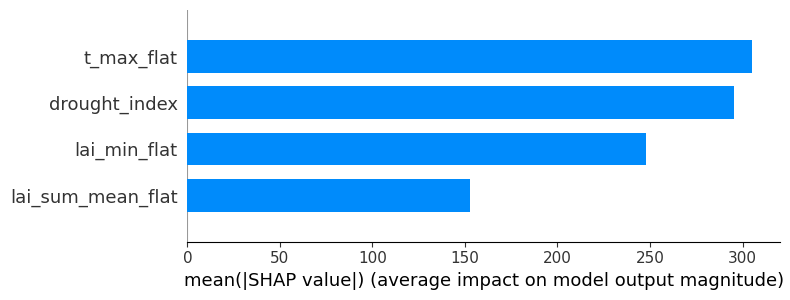

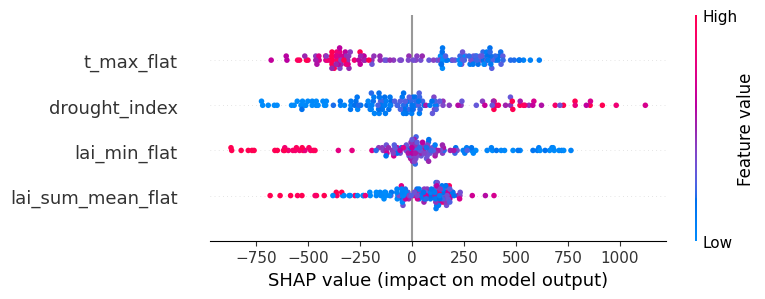

In [ ]:
# Initialize and train the model (assuming this has been done as shown previously)
# rf = RandomForestRegressor(n_estimators=1000, random_state=1, oob_score=True)
# rf.fit(X_train, y_train)

# Initialize SHAP Explainer
explainer = shap.TreeExplainer(rf)

# Compute SHAP values
shap_values = explainer.shap_values(X_train)

# Plot global feature importance
shap.summary_plot(shap_values, X_train, plot_type="bar", feature_names=['lai_min_flat', 'lai_sum_mean_flat', 't_max_flat', 'drought_index'])

# Detailed dot plot for all features
shap.summary_plot(shap_values, X_train, plot_type='dot', feature_names=[ 'lai_min_flat', 'lai_sum_mean_flat', 't_max_flat', 'drought_index'])

# Waterfall plot for the first instance in the test set
#shap.waterfall_plot(explainer.expected_value, shap_values_single, feature_names=['sm_min_flat', 'lai_min_flat', 'lai_sum_mean_flat', 't_max_flat', 'index_max_flat', 'index_severity_flat', 'index_len_flat'])

# Show the plots
plt.show()


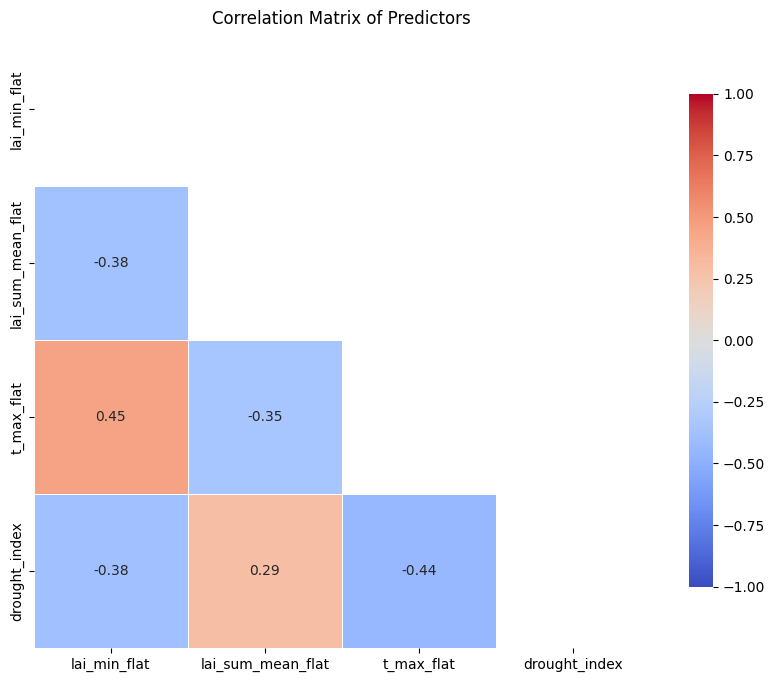

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X_clean is a numpy array with your cleaned predictors
# Create a DataFrame for better handling with columns named according to your predictors
# Only include the columns 'lai_min_flat', 'lai_sum_mean_flat', 't_max_flat', 'drought_index'
X_selected = X_clean[:, [0, 1, 2, 3]]  # Assuming the columns are in this order
column_names = ['lai_min_flat', 'lai_sum_mean_flat', 't_max_flat', 'drought_index']
df_predictors = pd.DataFrame(X_selected, columns=column_names)

# Compute the correlation matrix
corr_matrix = df_predictors.corr()

# Generate a mask for the upper triangle (optional, for aesthetics)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
            vmax=1, vmin=-1, square=True, linewidths=.5, cbar_kws={"shrink": .8})

# Add titles and labels for clarity
plt.title('Correlation Matrix of Predictors')
plt.show()

In [ ]:
# Compute mean SHAP values for each feature
mean_shap_values = np.mean(np.abs(shap_values), axis=0)

# Print mean values for each feature
for feature_name, mean_shap in zip(['sm_min_flat', 'lai_min_flat', 'lai_sum_mean_flat', 't_max_flat', 'index_max_flat', 'index_severity_flat', 'index_len_flat'], mean_shap_values):
    print(f"Mean SHAP value for {feature_name}: {mean_shap}")
